In [1]:
import json 
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from glob import glob 
os.chdir('../')

def load_df(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()
    df = pd.DataFrame(list(pd.Series(data).map(eval).values))    
    return df 

def load_log_data(class_name, version, result_dir,method):

    df = pd.DataFrame()
    for i,v in enumerate(version):
        log_dir = os.path.join(result_dir,class_name,method,v,'log.txt')
        
        temp_df = load_df(log_dir)
        temp_df['hue'] = v 
        
        df = pd.concat([df,temp_df])
    
    return df 

def plot_log(data,class_name, metrics:list, figsize:tuple = (10,7)):
    
    fig, axes = plt.subplots(len(metrics),1,figsize=figsize)
    
    for ax, metric in zip(axes, metrics):
        sns.lineplot(
            x = 'epoch',
            y = metric,
            data = data,
            hue = data['hue'],
            ax = ax 
        )
        
    fig.suptitle(class_name)
    plt.show()
    
def read_txt(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()    
    df = pd.DataFrame([eval(d) for d in data]) 
    return df 

In [2]:
version = ['noisedad-*-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0']
result_dir = './results/MVTecAD/'
method = 'PatchCore'

log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    auroc_list[class_name] = {'image_auroc':auroc[0], 'pixel_auroc':auroc[1]}
    temp_df = pd.DataFrame(auroc_list).T.reset_index().sort_values(by='index').reset_index(drop=True)
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    
    df = pd.concat([df,temp_df])
    
    
    
df.reset_index(drop=True,inplace=True)
df = df.sort_values(by=['index','anomaly_ratio']).reset_index(drop=True)
df.groupby(['index','sampling_method','anomaly_ratio'])[['image_auroc','pixel_auroc']].mean()

image_auroc  pixel_auroc
index  sampling_method anomaly_ratio                          
bottle gaussian        0.0               0.995455     0.987364
                       0.1               0.997727     0.987527
                       0.2               1.000000     0.987844
       identity        0.0               1.000000     0.987803
                       0.1               1.000000     0.989076
...                                           ...          ...
zipper lof             0.1               0.981954     0.986836
                       0.2               0.977993     0.986033
       nearest         0.0               0.974032     0.986357
                       0.1               0.974032     0.986763
                       0.2               0.976232     0.986694

[156 rows x 2 columns]

# Anomaly Type(structural, logical) 에 따라 

In [3]:
log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    
    data = pd.DataFrame(data['test_metrics'][0]).iloc[0,:].reset_index()
    temp_df = data 
    
    temp_df['class'] = class_name 
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    
    df = pd.concat([df,temp_df])
    
    

In [4]:
df = df.melt(['index','class','anomaly_ratio','sampling_method'])

# sampling method identity,랑 lof만 남기기 
df = df[(df['sampling_method'] =='identity') | (df['sampling_method'] =='lof')].reset_index(drop=True)

# 이름 바꾸기 
df.loc[df['sampling_method']=='identity','sampling_method'] = 'PatchCore'
df.loc[df['sampling_method']=='lof','sampling_method'] = 'SoftPatch'

plot_df = df.groupby(['variable','anomaly_ratio','sampling_method','index','class'])['value'].mean().reset_index()
# plot_df = plot_df[plot_df['index'] == 'img_level'].reset_index(drop=True)

result = plot_df.pivot_table(index=['class','sampling_method','index'],columns=['variable','anomaly_ratio'],values='value')
result

variable                                 auroc                    
anomaly_ratio                              0.0       0.1       0.2
class      sampling_method index                                  
bottle     PatchCore       img_level  1.000000  1.000000  1.000000
                           pix_level  0.987803  0.989076  0.987270
           SoftPatch       img_level  1.000000  1.000000  1.000000
                           pix_level  0.988935  0.988927  0.990553
cable      PatchCore       img_level  0.969109  0.950431  0.945043
                           pix_level  0.983829  0.811970  0.781785
           SoftPatch       img_level  0.965517  0.960489  0.957256
                           pix_level  0.982397  0.982630  0.981115
capsule    PatchCore       img_level  0.986166  0.978920  0.969697
                           pix_level  0.990331  0.983304  0.982896
           SoftPatch       img_level  0.954545  0.959157  0.964427
                           pix_level  0.987001  0.987362  0.987809
carpet     PatchCore       img_level  0.990260  0.998918  1.000000
                           pix_level  0.992880  0.991977  0.992161
           SoftPatch       img_level  0.991342  0.997835  1.000000
                           pix_level  0.989810  0.990534  0.990920
grid       PatchCore       img_level  1.000000  0.990476  0.980952
                           pix_level  0.996919  0.996970  0.996208
           SoftPatch       img_level  0.990476  1.000000  1.000000
                           pix_level  0.996387  0.996599  0.996657
leather    PatchCore       img_level  1.000000  0.998547  0.997093
                           pix_level  0.993472  0.994270  0.994572
           SoftPatch       img_level  1.000000  1.000000  1.000000
                           pix_level  0.994150  0.994324  0.994463
metal_nut  PatchCore       img_level  0.998145  0.987941  0.969388
                           pix_level  0.983949  0.837569  0.783373
           SoftPatch       img_level  1.000000  0.998145  0.996289
                           pix_level  0.983964  0.981491  0.838265
pill       PatchCore       img_level  0.939685  0.929196  0.900350
                           pix_level  0.975179  0.887794  0.802599
           SoftPatch       img_level  0.938374  0.941871  0.934441
                           pix_level  0.970825  0.965825  0.965818
screw      PatchCore       img_level  0.986696  0.970732  0.956541
                           pix_level  0.995950  0.996168  0.995785
           SoftPatch       img_level  0.964523  0.946341  0.944568
                           pix_level  0.993557  0.992994  0.992889
tile       PatchCore       img_level  0.974482  0.976077  0.977671
                           pix_level  0.962014  0.954125  0.953163
           SoftPatch       img_level  0.978469  0.977671  0.975279
                           pix_level  0.963958  0.965035  0.961272
toothbrush PatchCore       img_level  1.000000  1.000000  1.000000
                           pix_level  0.989113  0.990943  0.991035
           SoftPatch       img_level  1.000000  1.000000  0.995370
                           pix_level  0.989150  0.989592  0.989197
wood       PatchCore       img_level  0.990431  0.980861  0.961722
                           pix_level  0.952355  0.952024  0.954633
           SoftPatch       img_level  0.990431  0.990431  0.995215
                           pix_level  0.952457  0.955607  0.954655
zipper     PatchCore       img_level  0.998680  0.992958  0.987236
                           pix_level  0.987673  0.986138  0.984915
           SoftPatch       img_level  0.982394  0.981954  0.977993
                           pix_level  0.986649  0.986836  0.986033

In [6]:
log_dirs

['./results/MVTecAD/PatchCore/wood/noisedad-nearest-sampling_ratio_0.1-anomaly_ratio_0.0-n_query_0/seed_0/log.txt',
 './results/MVTecAD/PatchCore/wood/noisedad-identity-sampling_ratio_0.1-anomaly_ratio_0.1-n_query_0/seed_0/log.txt',
 './results/MVTecAD/PatchCore/wood/noisedad-nearest-sampling_ratio_0.1-anomaly_ratio_0.1-n_query_0/seed_0/log.txt',
 './results/MVTecAD/PatchCore/wood/noisedad-nearest-sampling_ratio_0.1-anomaly_ratio_0.2-n_query_0/seed_0/log.txt',
 './results/MVTecAD/PatchCore/wood/noisedad-lof-sampling_ratio_0.1-anomaly_ratio_0.0-n_query_0/seed_0/log.txt',
 './results/MVTecAD/PatchCore/wood/noisedad-gaussian-sampling_ratio_0.1-anomaly_ratio_0.2-n_query_0/seed_0/log.txt',
 './results/MVTecAD/PatchCore/wood/noisedad-identity-sampling_ratio_0.1-anomaly_ratio_0.2-n_query_0/seed_0/log.txt',
 './results/MVTecAD/PatchCore/wood/noisedad-identity-sampling_ratio_0.1-anomaly_ratio_0.0-n_query_0/seed_0/log.txt',
 './results/MVTecAD/PatchCore/wood/noisedad-lof-sampling_ratio_0.1-anoma

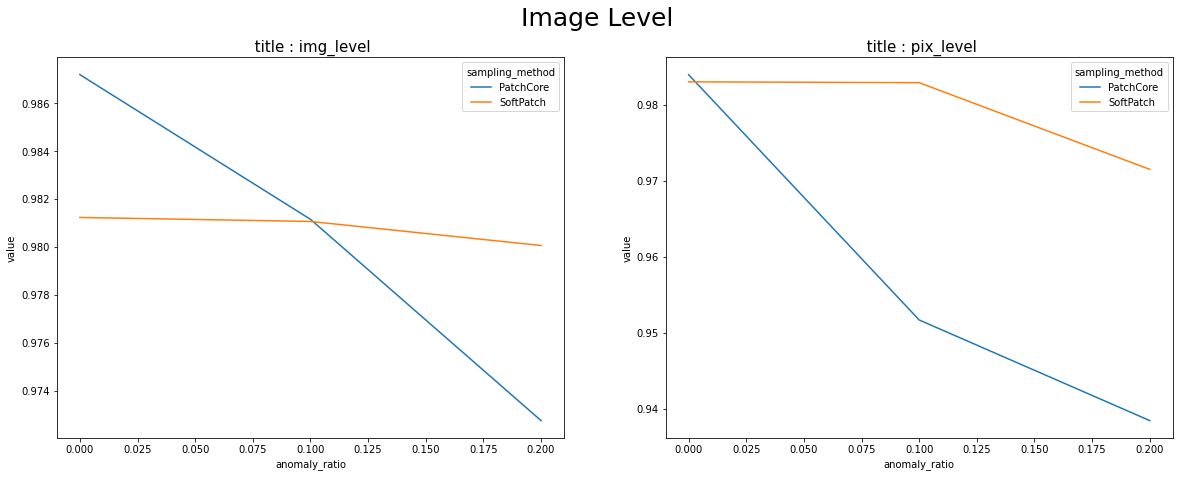

In [5]:
plot_df = df.groupby(['variable','sampling_method','anomaly_ratio','index'])['value'].mean().reset_index()

fig,axes = plt.subplots(1,2, figsize=(20,7))

for i, a_type in enumerate(['img_level','pix_level']):
    sns.lineplot(
        x = 'anomaly_ratio',
        y = 'value',
        hue = 'sampling_method',
        data = plot_df[plot_df['index'] == a_type].reset_index(drop=True),
        ax = axes[i]
    )   
    
    axes[i].set_title(f" title : {a_type}",size=15)

fig.suptitle(' Image Level ', fontsize=25)
plt.show()


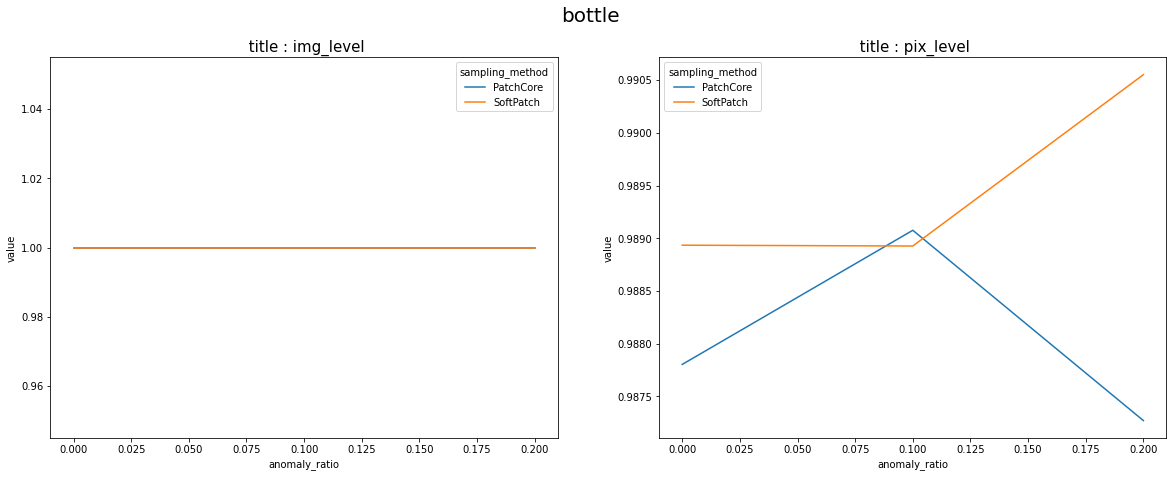

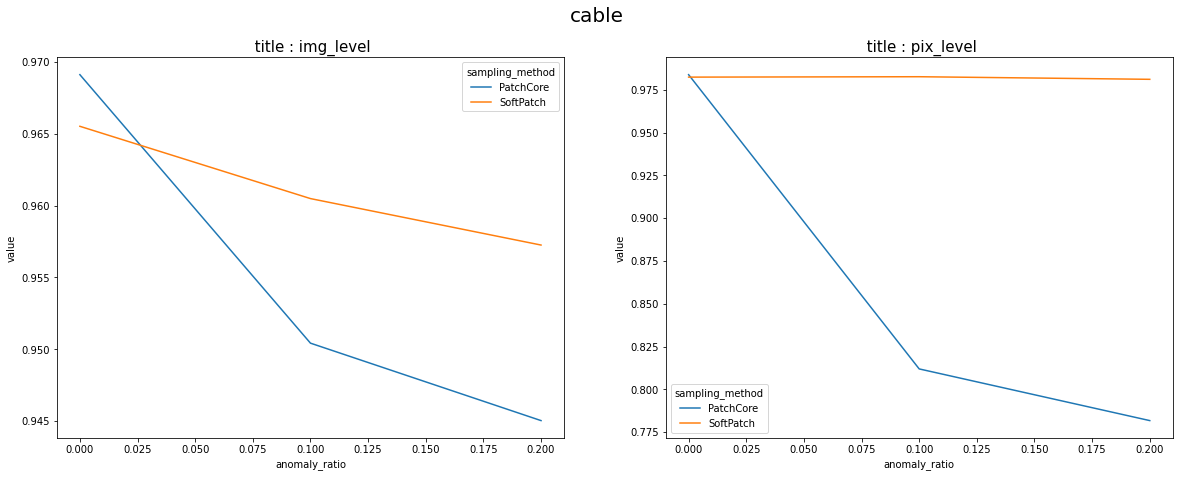

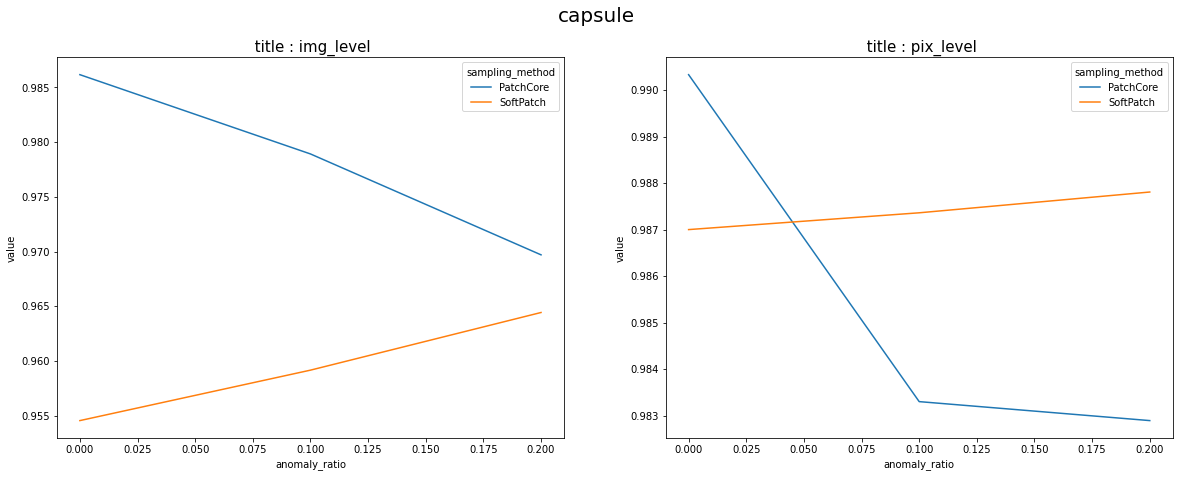

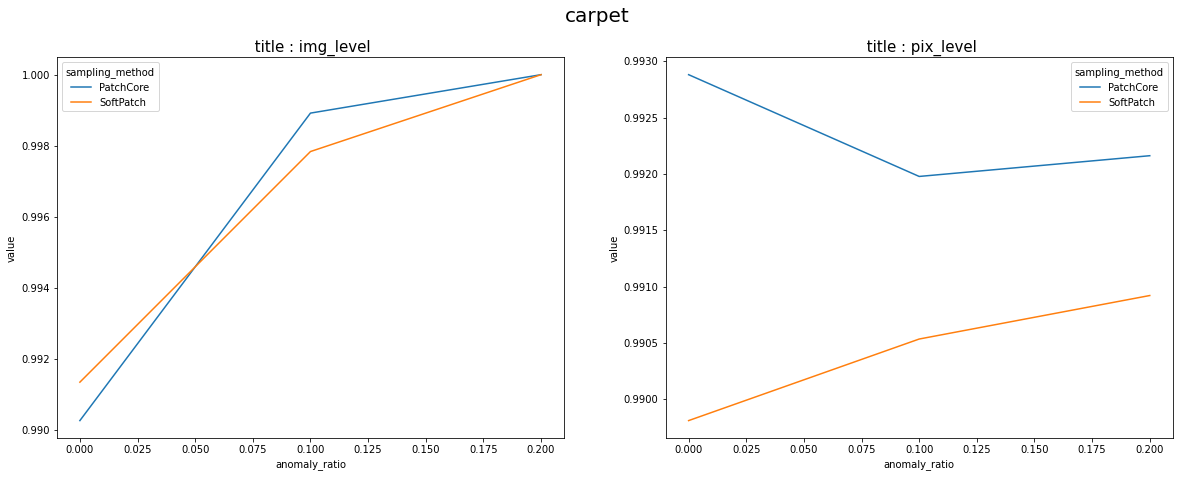

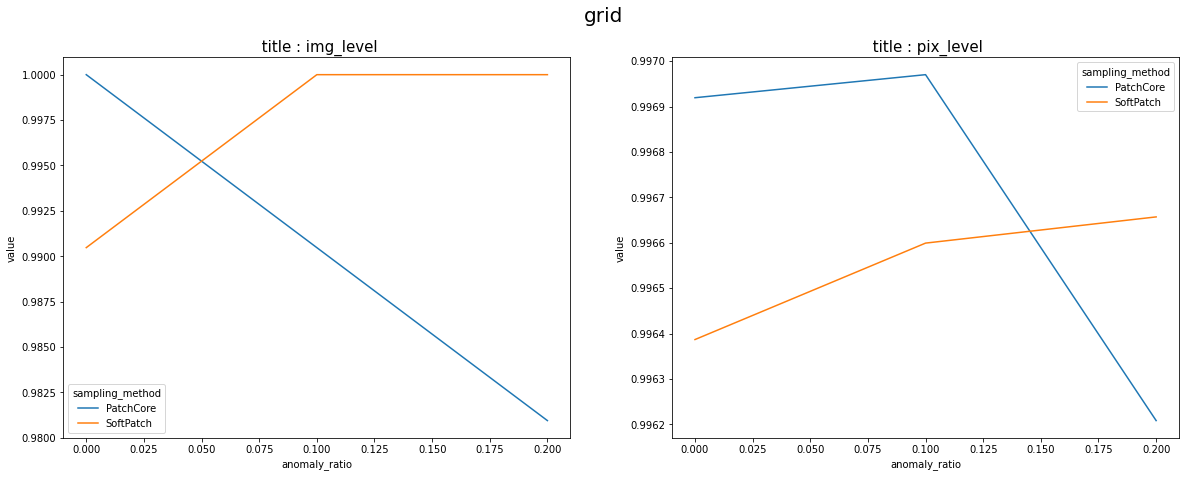

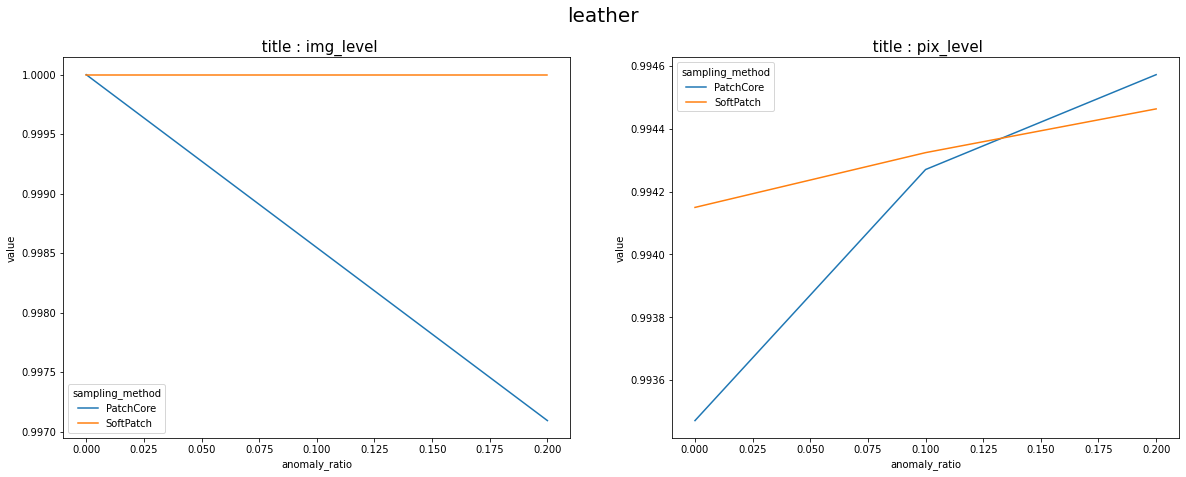

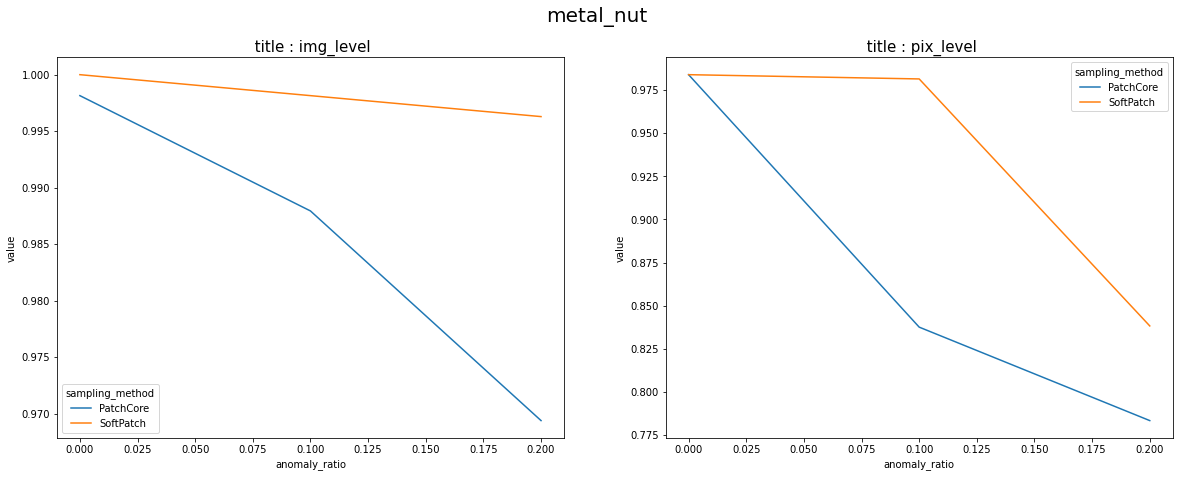

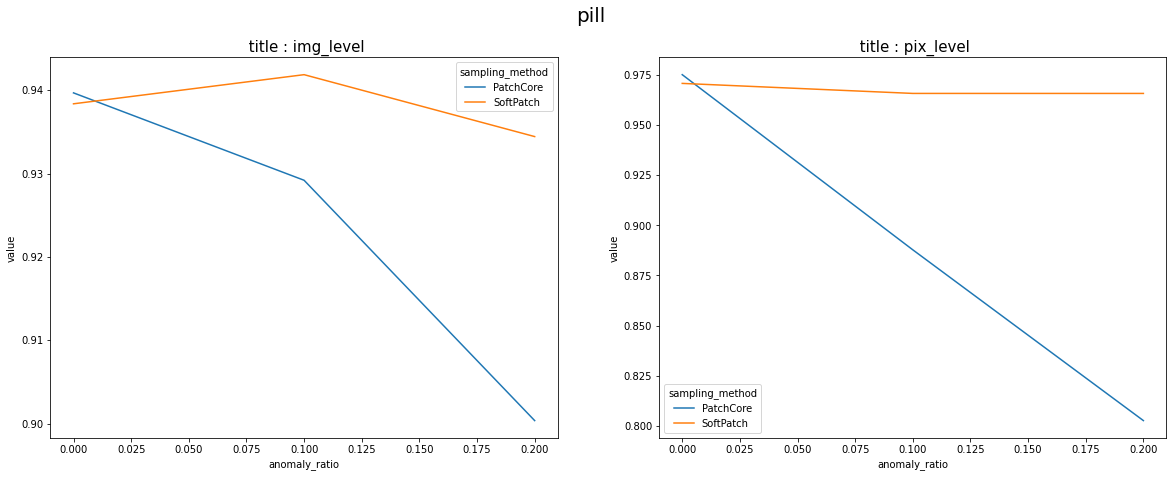

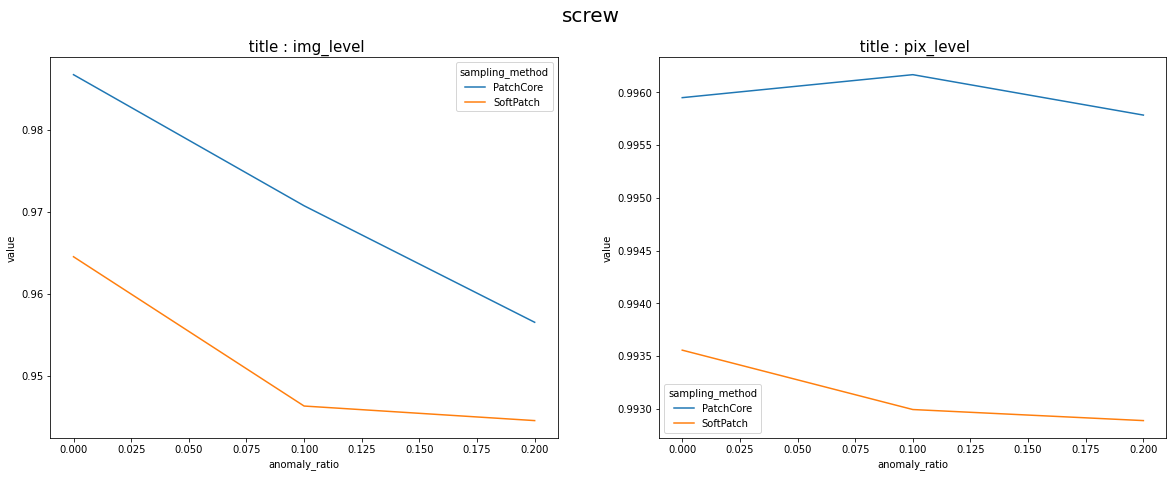

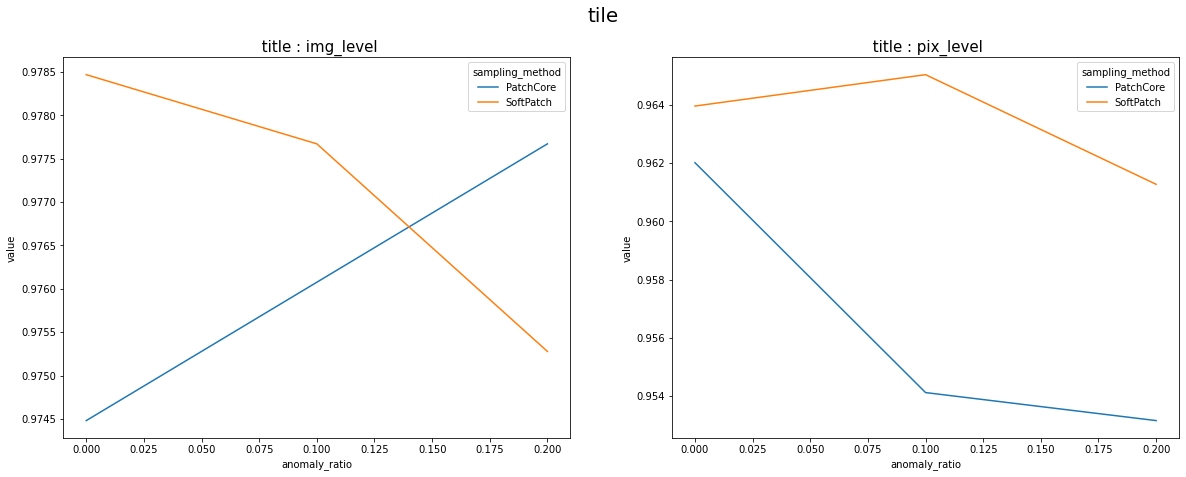

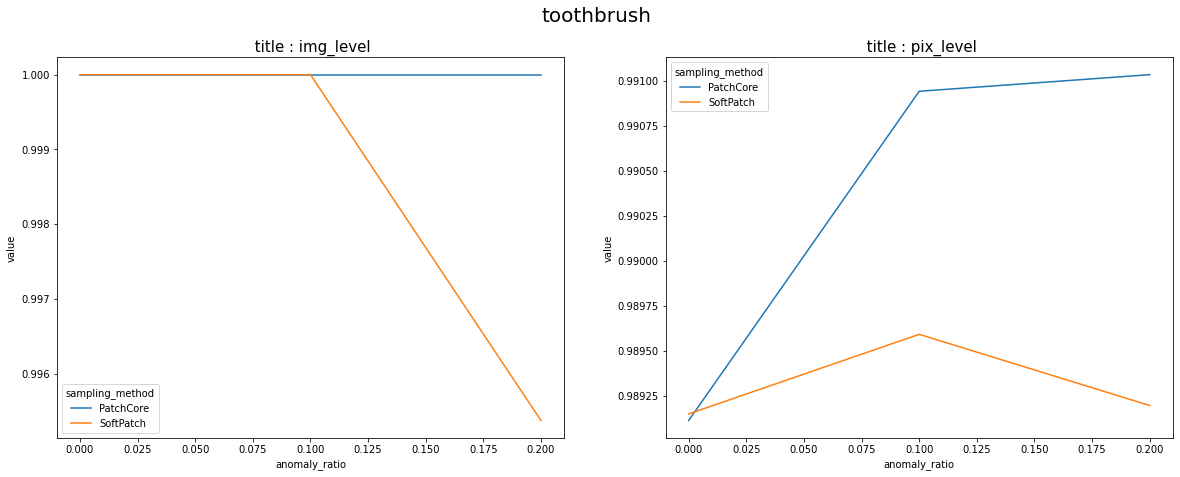

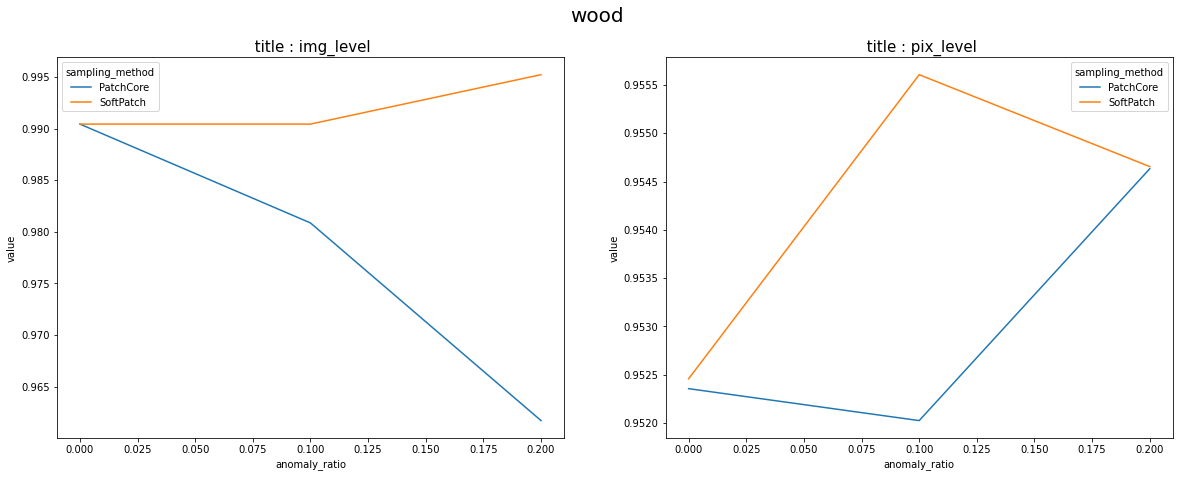

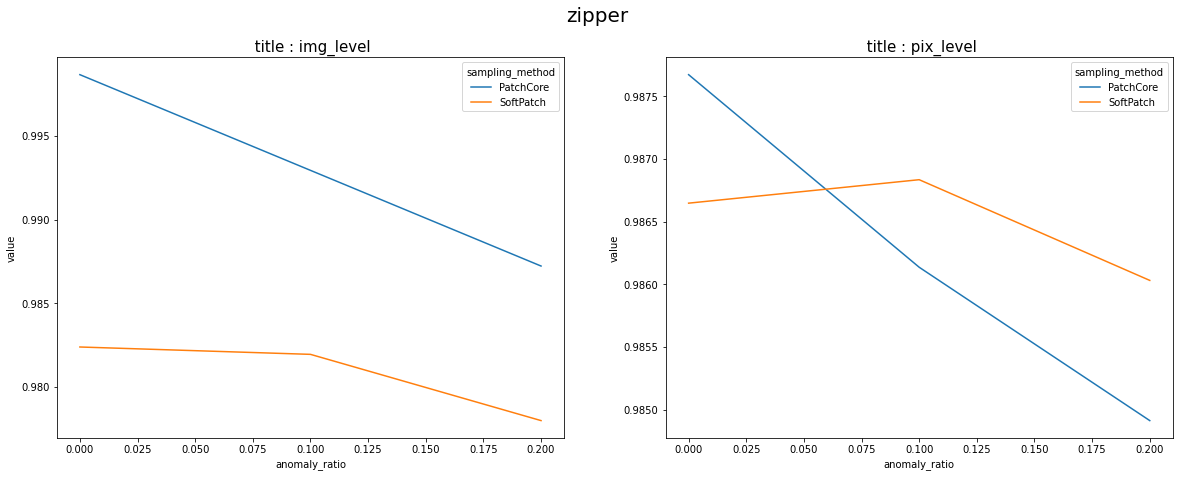

In [7]:
plot_df = df.groupby(['variable','sampling_method','anomaly_ratio','index','class'])['value'].mean().reset_index()

for class_name in plot_df['class'].unique():
    fig,axes = plt.subplots(1,2, figsize=(20,7))

    for i, a_type in enumerate(['img_level','pix_level']):
        sns.lineplot(
            x = 'anomaly_ratio',
            y = 'value',
            hue = 'sampling_method',
            data = plot_df[(plot_df['index'] == a_type) & (plot_df['class']==class_name)],
            ax = axes[i]
        )   
        
        axes[i].set_title(f" title : {a_type}",size=15)
    fig.suptitle(class_name,size=20)
    
    plt.show()


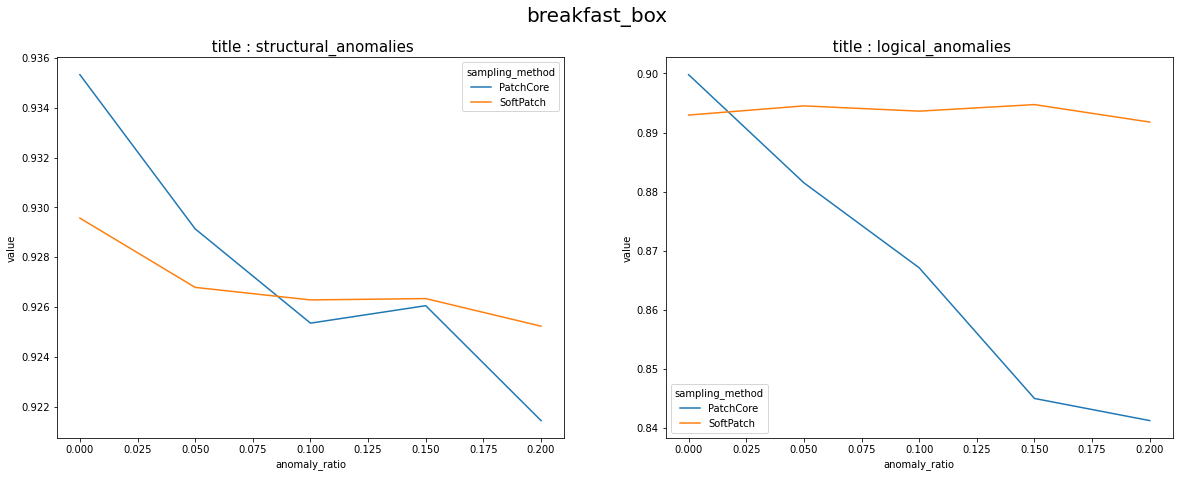

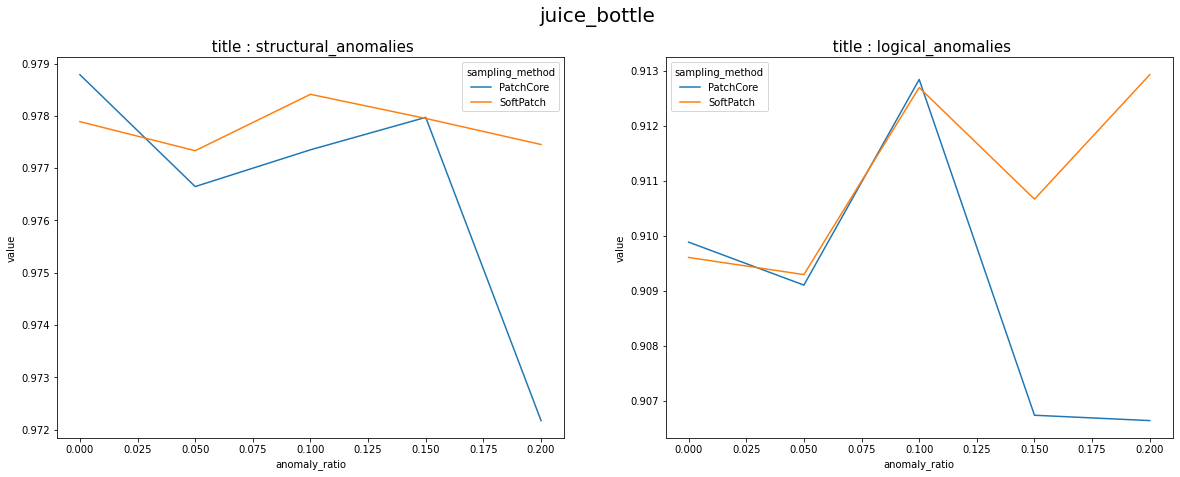

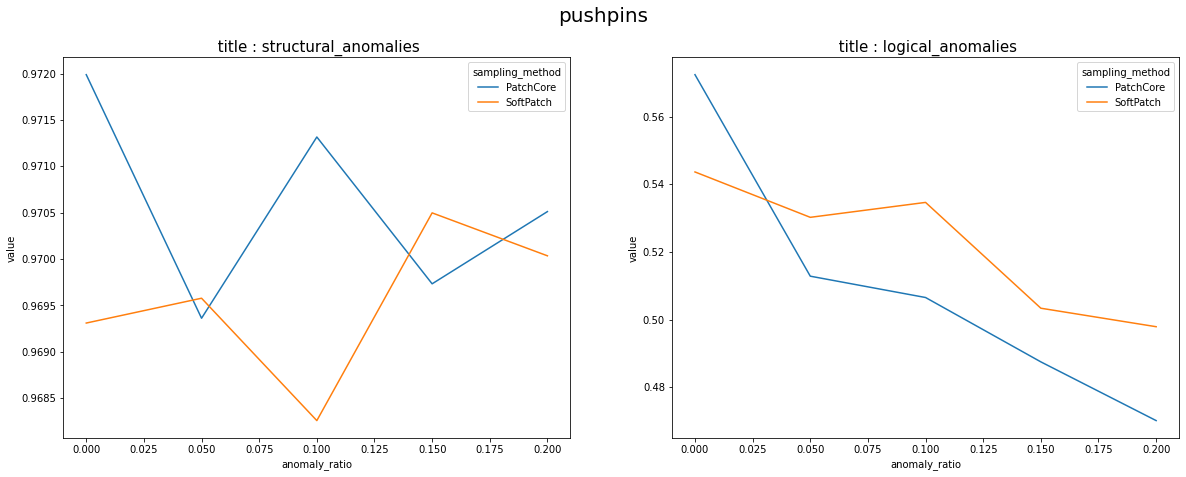

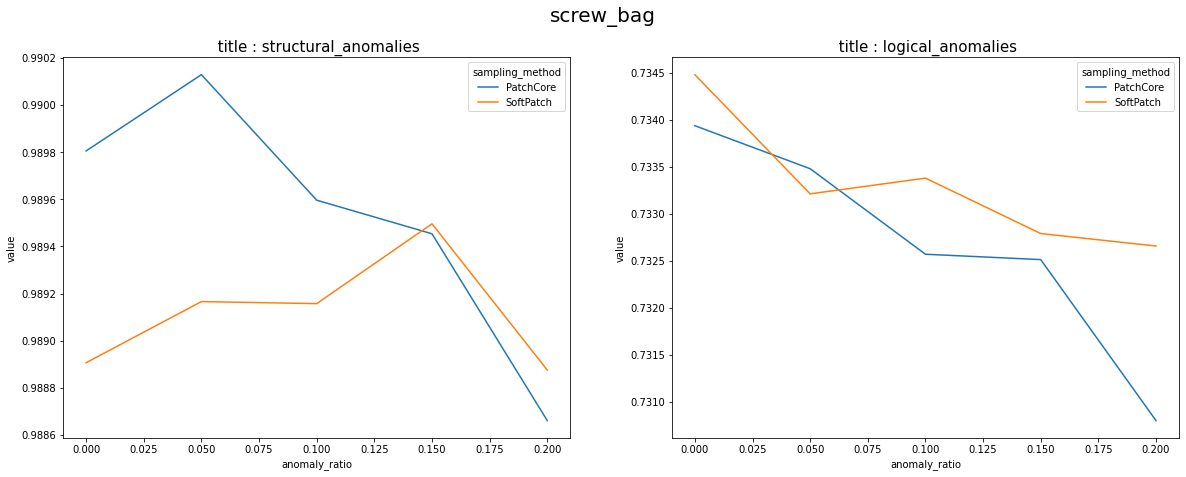

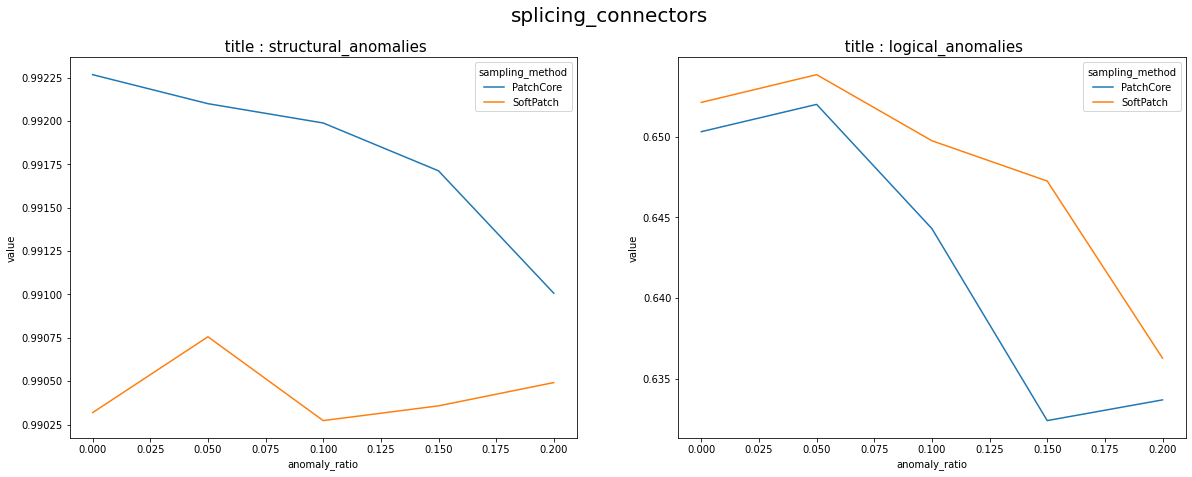

In [8]:
plot_df = df.groupby(['variable','sampling_method','anomaly_ratio','index','class'])['value'].mean().reset_index()
plot_df = plot_df[plot_df['index'] == 'pix_level'].reset_index(drop=True)
for class_name in plot_df['class'].unique():
    fig,axes = plt.subplots(1,2, figsize=(20,7))

    for i, a_type in enumerate(['structural_anomalies','logical_anomalies']):
        sns.lineplot(
            x = 'anomaly_ratio',
            y = 'value',
            hue = 'sampling_method',
            data = plot_df[(plot_df['variable'] == a_type) & (plot_df['class']==class_name)],
            ax = axes[i]
        )   
        
        axes[i].set_title(f" title : {a_type}",size=15)
    fig.suptitle(class_name,size=20)
    
    plt.show()
